In [119]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import copy
import csv
import glob
from tqdm import notebook as tqdm
import itertools

sns.set()
sns.set_style('white', {'axes.grid': True })

params = {
    'legend.fontsize': 38,
    'figure.figsize': (36, 36),
    'axes.labelsize': 36,
    'axes.titlesize': 42,
    'xtick.labelsize': 28,
    'ytick.labelsize': 28
}

plt.rcParams.update(params)

## Setting up models, transformations, search methods, constraint levels, etc.

In [120]:
models = ["bert-yelp-test", "bert-mr-test", "bert-snli-test"]
#models = ["lstm-yelp-test", "lstm-mr-test"]
model_dataset_names = {
    "bert-mr-test": "Movie Reviews",
    "bert-yelp-test": "Yelp Polarity",
    "bert-snli-test": "SNLI",
    "lstm-mr-test": "LSTM Movie Reviews",
    "lstm-yelp-test": "LSTM Yelp Polarity",
}
transformations = ["word-swap-embedding", "word-swap-hownet", "word-swap-wordnet"]
transformation_names = {
    "word-swap-embedding": "Word Embedding",
    "word-swap-hownet": "HowNet",
    "word-swap-wordnet": "WordNet",
}
constraint_levels = ["lax", "strict"]
search_methods = ["greedy", "beam4", "beam8", "greedyWIR_unk", "greedyWIR_delete", "greedyWIR_random", "greedyWIR_pwws", "genetic", "pso"]
search_method_names = {
    'greedy': 'Greedy [b=1]',
    'beam4': 'Beam Search [b=4]',
    'beam8': 'Beam Search [b=8]',
    'greedyWIR_unk': 'Greedy WIR [UNK]',
    'greedyWIR_delete': 'Greedy WIR [DEL]',
    'greedyWIR_random': 'Greedy WIR [RAND]',
    'greedyWIR_pwws': 'Greedy WIR [PWWS]',
    'genetic': 'Genetic Algorithm',
    'pso': 'Particle Swarm Optimization'
}

## Grabbing results from CSV files

In [121]:
RESULT_ROOT_DIR = "./results"
def process_csv(model, transformation, constraint_level, search):
    csv_file_path = f"{RESULT_ROOT_DIR}/{model}/{transformation}/{constraint_level}/{search}.csv"
    with open(csv_file_path) as f:
        rows = [{k: v for k, v in row.items()}
            for row in csv.DictReader(f, skipinitialspace=True)]
        for _dict in rows:
            _dict['model'] = model
            _dict['dataset'] = model_dataset_names[model]
            _dict['search'] = search_method_names[search]
            _dict['constraint'] = constraint_level
            _dict['transformation'] = transformation
            original_words = np.array(_dict['original_text'].split())
            perturbed_words = np.array(_dict['perturbed_text'].split())
            _dict['num_swaps'] = (original_words != perturbed_words).sum()
            _dict['num_words'] = _dict['original_text'].count(' ')
        return rows

In [122]:
CSV_DATA = []
num_files = len(models) * len(transformations) * len(constraint_levels) * len(search_methods)
pbar = tqdm.tqdm(total=num_files, smoothing=0)
for model in models:
    for t in transformations:
        for cl in constraint_levels:
            for sm in search_methods:
                if sm == "pso" and model =="bert-yelp-test" and t != "word-swap-wordnet":
                    continue
                CSV_DATA.extend(process_csv(model, t, cl, sm))
                pbar.update(1)
pbar.close()
df = pd.DataFrame(CSV_DATA)
col_type_tuples = [('num_words', int), ('num_swaps', int)]
for col_name, col_type in col_type_tuples:
     df[col_name] = df[col_name].astype(col_type)
print(f'Got {len(df)} results across {num_files} CSVs.')


Got 144992 results across 162 CSVs.


## Query Budget Graphs

We want to compare attacks within a _query budget_ -- that is, how many successful attacks are there at a given query budget? So let's just take attacks from within the *strict* constraint level and compare their successes at a given query budget.

In [123]:
CONSTRAINT_LEVEL = "strict"
FIGURES_DIR = "./figures"
linestyle_map = {
    'Greedy [b=1]': ':', 
    'Beam Search [b=4]': ':',
    'Beam Search [b=8]': ':',
    'Greedy WIR [UNK]': '--',
    'Greedy WIR [DEL]': '--',
    'Greedy WIR [RAND]': '--',
    'Greedy WIR [PWWS]': '--',
    'Genetic Algorithm': '-',
    'Particle Swarm Optimization': '-'
}

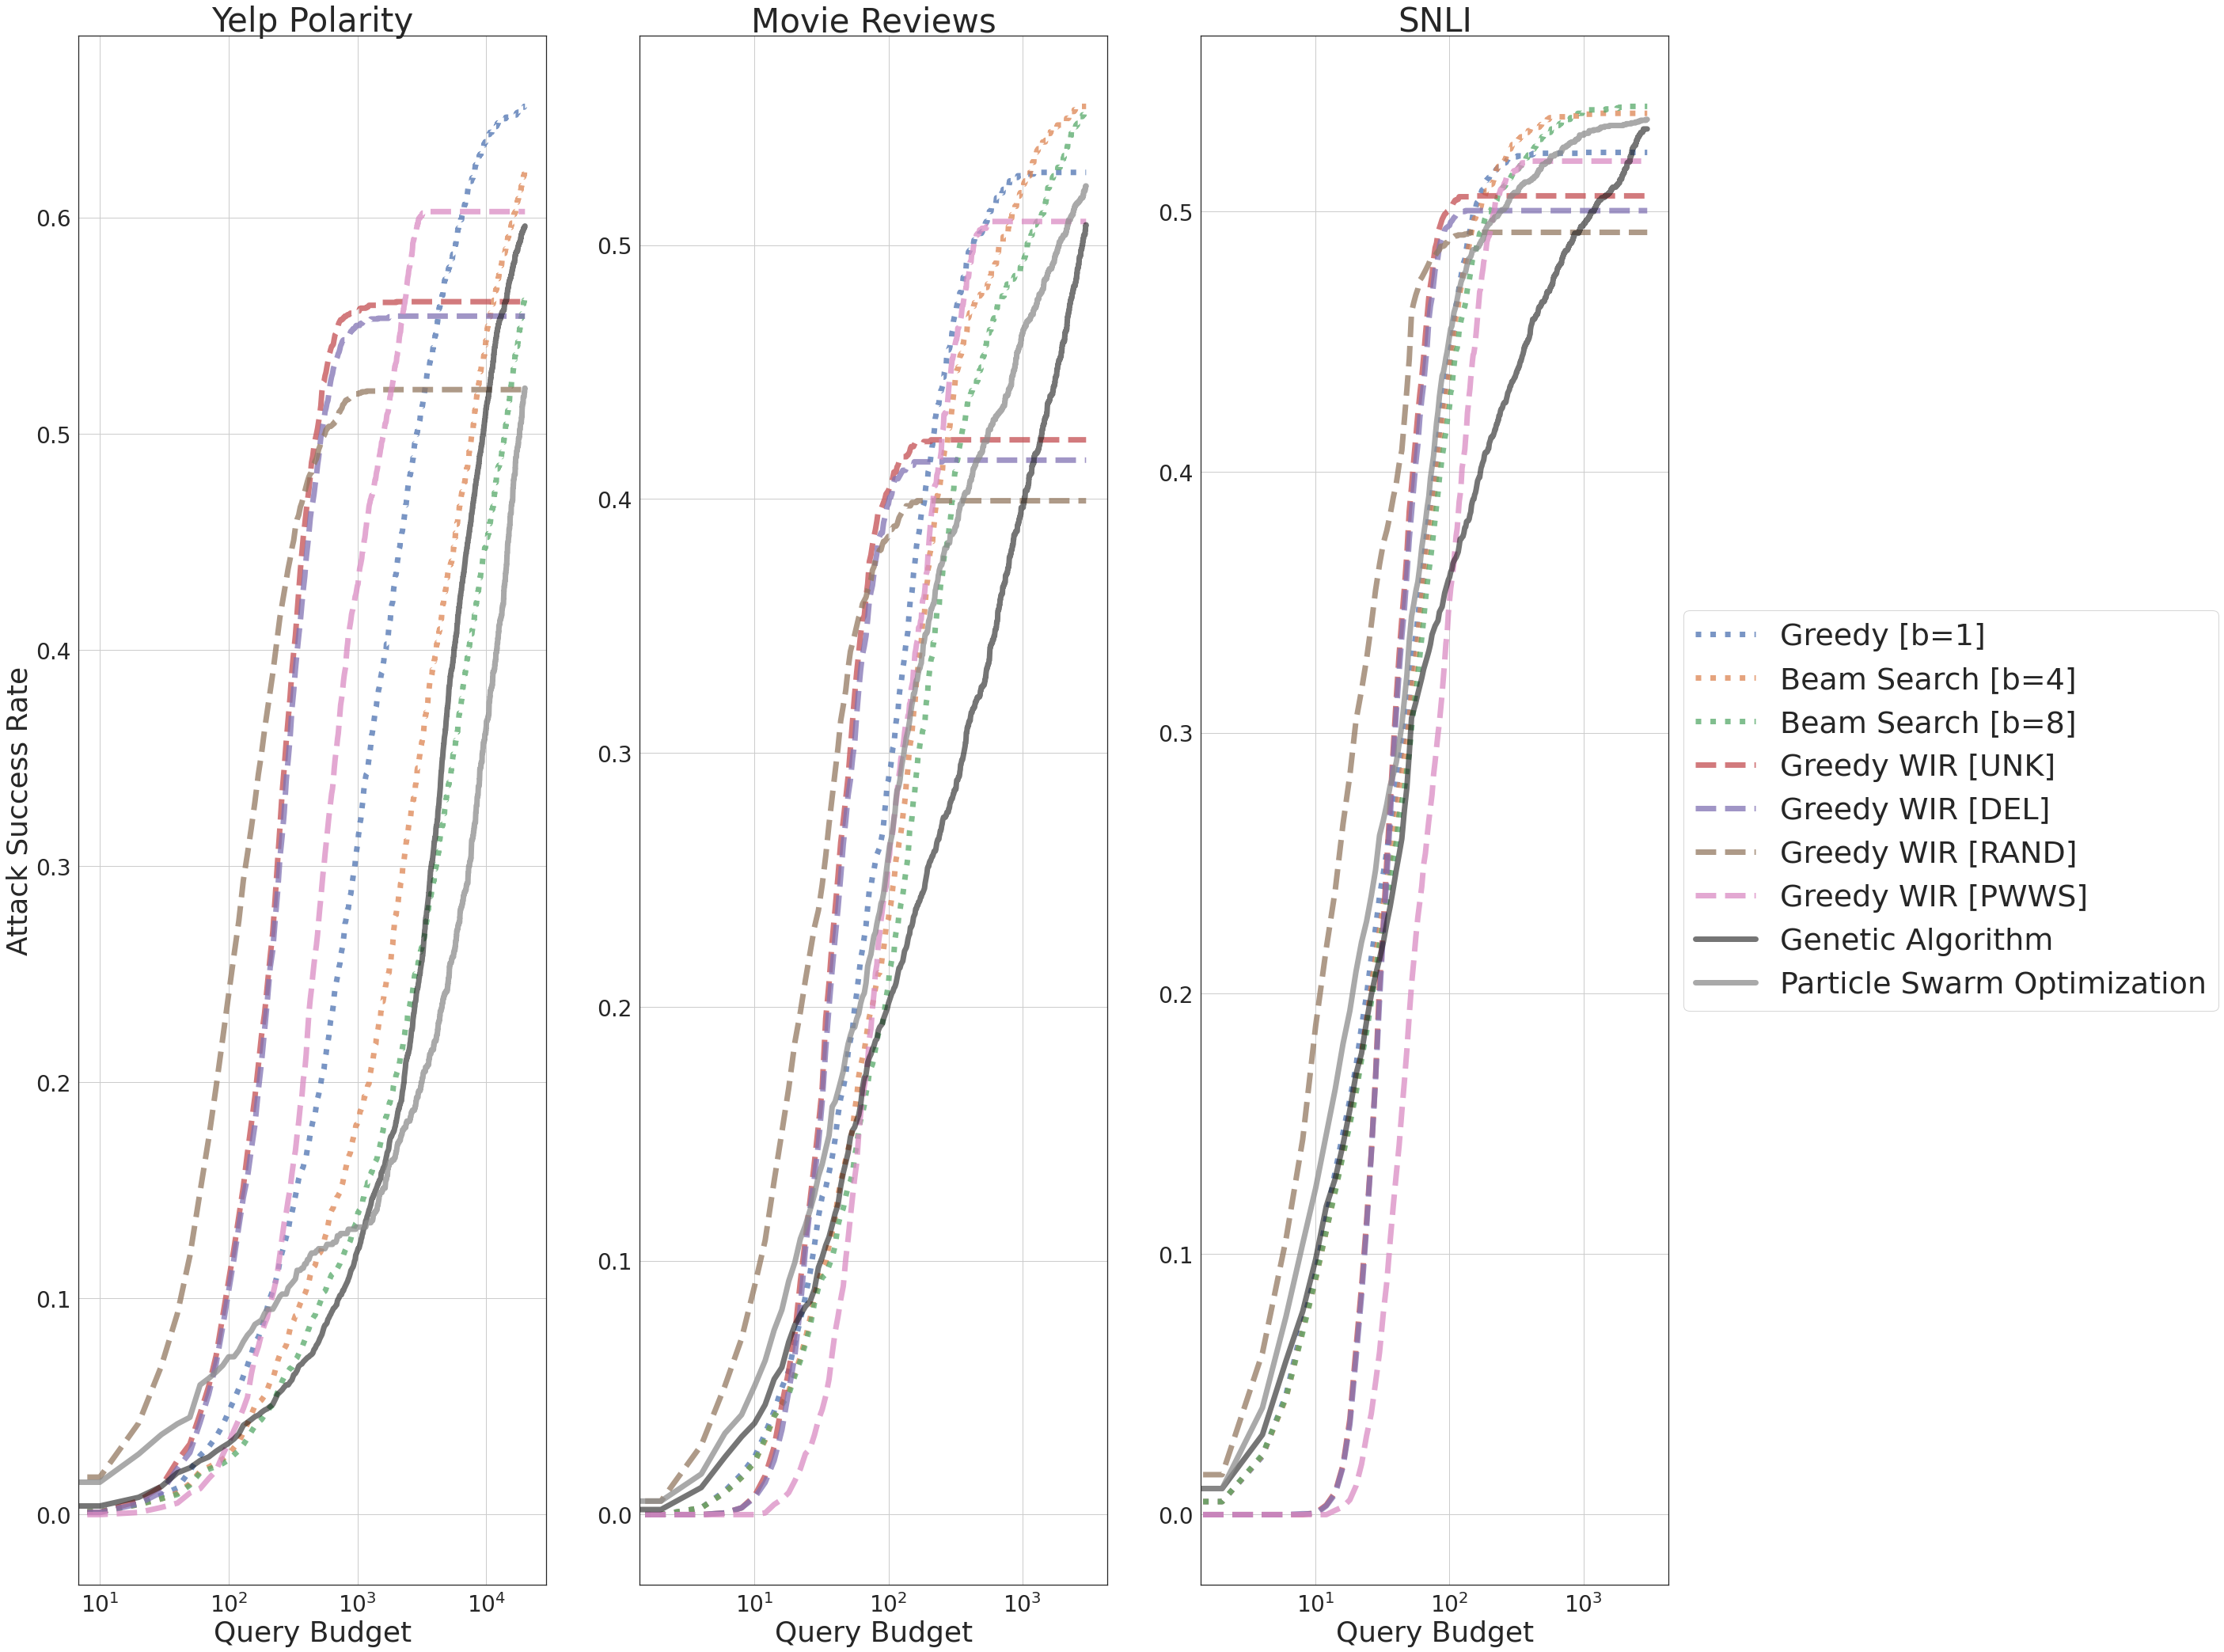

In [124]:
num_bins = 10
model_names = sorted(df['model'].unique())[::-1]
fig, axes = plt.subplots(ncols=len(model_names), sharey=False)

SHOW_PERC = True # Whether to attack success rate (percentage) instead of number of total successes.
for i, model in enumerate(models):
    if model == 'bert-yelp-test':
        QC_threshs = range(0, 20000, 10)
    else:
        QC_threshs = range(0, 3000, 2)
    target_df = df[(df['constraint'] == CONSTRAINT_LEVEL) & (df['model'] == model)].reset_index()
    dataset = model_dataset_names[model]
    for search in search_methods:
        search = search_method_names[search]
        search_results = target_df[target_df['search'] == search]
        num_skipped_attacks = len(search_results[search_results['result_type']=="Skipped"])
        all_successful_attacks = search_results[search_results['result_type']=="Successful"]
        total_num_attacks = len(search_results[search_results['result_type']!="Skipped"])
        successful_attacks_count = []
        for thresh in QC_threshs:
            num_successful_attacks = (all_successful_attacks['num_queries'].astype(float) <= thresh).sum()
            if SHOW_PERC:
                successful_attacks_count.append(num_successful_attacks / total_num_attacks)
            else:
                successful_attacks_count.append(num_successful_attacks)
        if search == 'Genetic Algorithm':
            axes[i].plot(QC_threshs, successful_attacks_count, label=search, lw=7, alpha=.6, c='k', linestyle=linestyle_map[search])
        else:
            axes[i].plot(QC_threshs, successful_attacks_count, label=search, lw=7, alpha=.75, linestyle=linestyle_map[search])
    
    axes[i].set_title(dataset)
    axes[i].set_xscale('log')
    if i == 0:
        if SHOW_PERC:
            axes[i].set_ylabel('Attack Success Rate')
        else:
            axes[i].set_ylabel('Num. Successes')
    axes[i].set_xlabel('Query Budget')
    if i==len(model_names)-1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=False)

model_type = models[0].split("-")[0]
transformation_type = transformations[0].split("-")[-1]

plt.savefig(f'{FIGURES_DIR}/{model_type}-{transformation_type}-{CONSTRAINT_LEVEL}-successes_by_query_budget.pdf', bbox_inches='tight')

/p/qdata/jy2ma/miniconda3/envs/textattack/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


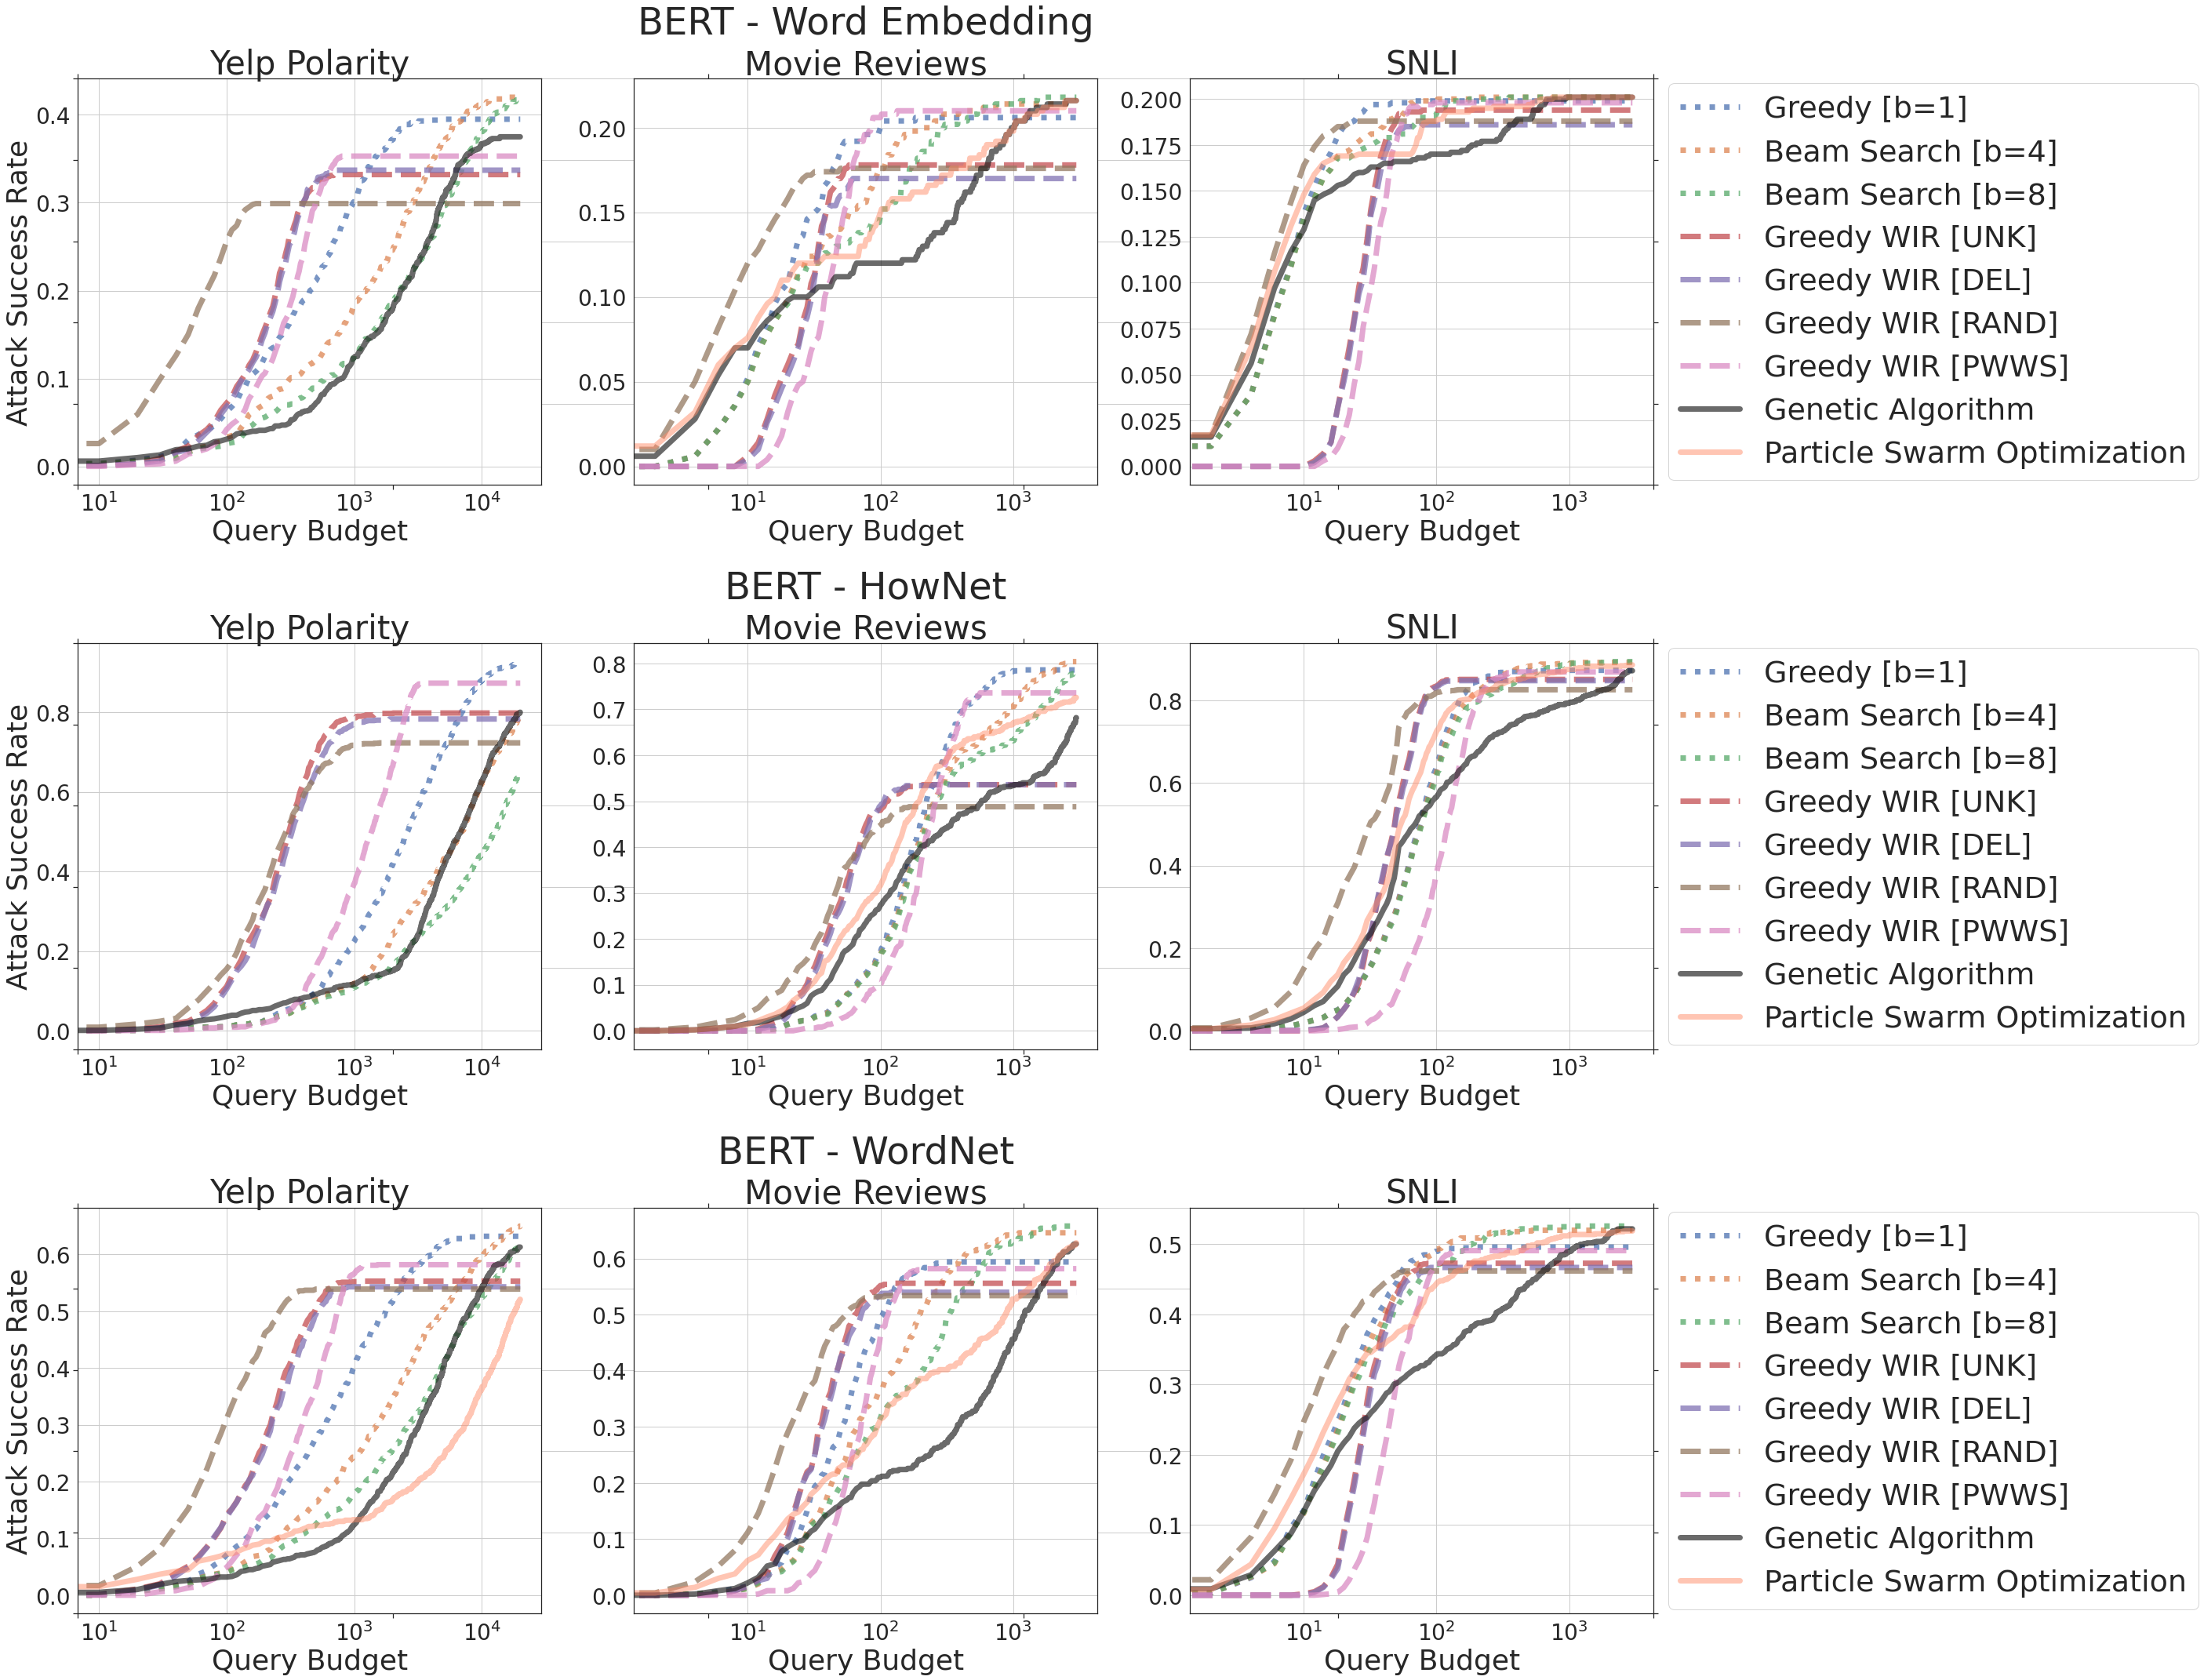

In [131]:
num_bins = 10
model_names = sorted(df['model'].unique())[::-1]
fig, big_axes = plt.subplots(len(transformations), sharey=False, sharex=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.39)
SHOW_PERC = True # Whether to attack success rate (percentage) instead of number of total successes.
i = 1
j = 0
for transformation in transformations:
    row_title = f"BERT - {transformation_names[transformation]}"
    plt.text(0.5, 1.11, row_title,
         horizontalalignment='center',
         fontsize=48,
         transform = big_axes[j].transAxes)
    big_axes[j].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_axes[j]._frameon = False
    j += 1
    for model in models:
        ax = fig.add_subplot(len(transformations),len(models),i)
        if model == 'bert-yelp-test':
            QC_threshs = range(0, 20000, 10)
        else:
            QC_threshs = range(0, 3000, 2)
        target_df = df[(df['constraint'] == CONSTRAINT_LEVEL) & (df['model'] == model) & (df['transformation'] == transformation)].reset_index()
        dataset = model_dataset_names[model]
        for search in search_methods:
            search = search_method_names[search]
            search_results = target_df[target_df['search'] == search]
            num_skipped_attacks = len(search_results[search_results['result_type']=="Skipped"])
            all_successful_attacks = search_results[search_results['result_type']=="Successful"]
            total_num_attacks = len(search_results[search_results['result_type']!="Skipped"])
            successful_attacks_count = []
            for thresh in QC_threshs:
                num_successful_attacks = (all_successful_attacks['num_queries'].astype(float) <= thresh).sum()
                if SHOW_PERC:
                    successful_attacks_count.append(num_successful_attacks / total_num_attacks)
                else:
                    successful_attacks_count.append(num_successful_attacks)
            if search == 'Genetic Algorithm':
                ax.plot(QC_threshs, successful_attacks_count, label=search, lw=7, alpha=.65, c='k', linestyle=linestyle_map[search])
            elif search == 'Particle Swarm Optimization':
                ax.plot(QC_threshs, successful_attacks_count, label=search, lw=7, alpha=.5, c='#ff8c69', linestyle=linestyle_map[search])
            else:
                ax.plot(QC_threshs, successful_attacks_count, label=search, lw=7, alpha=.75, linestyle=linestyle_map[search])

        ax.set_title(dataset)
        ax.set_xscale('log')
        if i % 3 == 1:
            if SHOW_PERC:
                ax.set_ylabel('Attack Success Rate')
            else:
                ax.set_ylabel('Num. Successes')
        ax.set_xlabel('Query Budget')
        if i % 3 == 0:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=False)
        i+= 1

plt.savefig(f'{FIGURES_DIR}/{model_type}-{CONSTRAINT_LEVEL}-successes_by_query_budget.pdf', bbox_inches='tight')

## Runtime Graphs

As our second analysis, we want to compare attack runtimes (in terms of number of queries) for different-length inputs.

KeyError: 'Yelp Polarity'

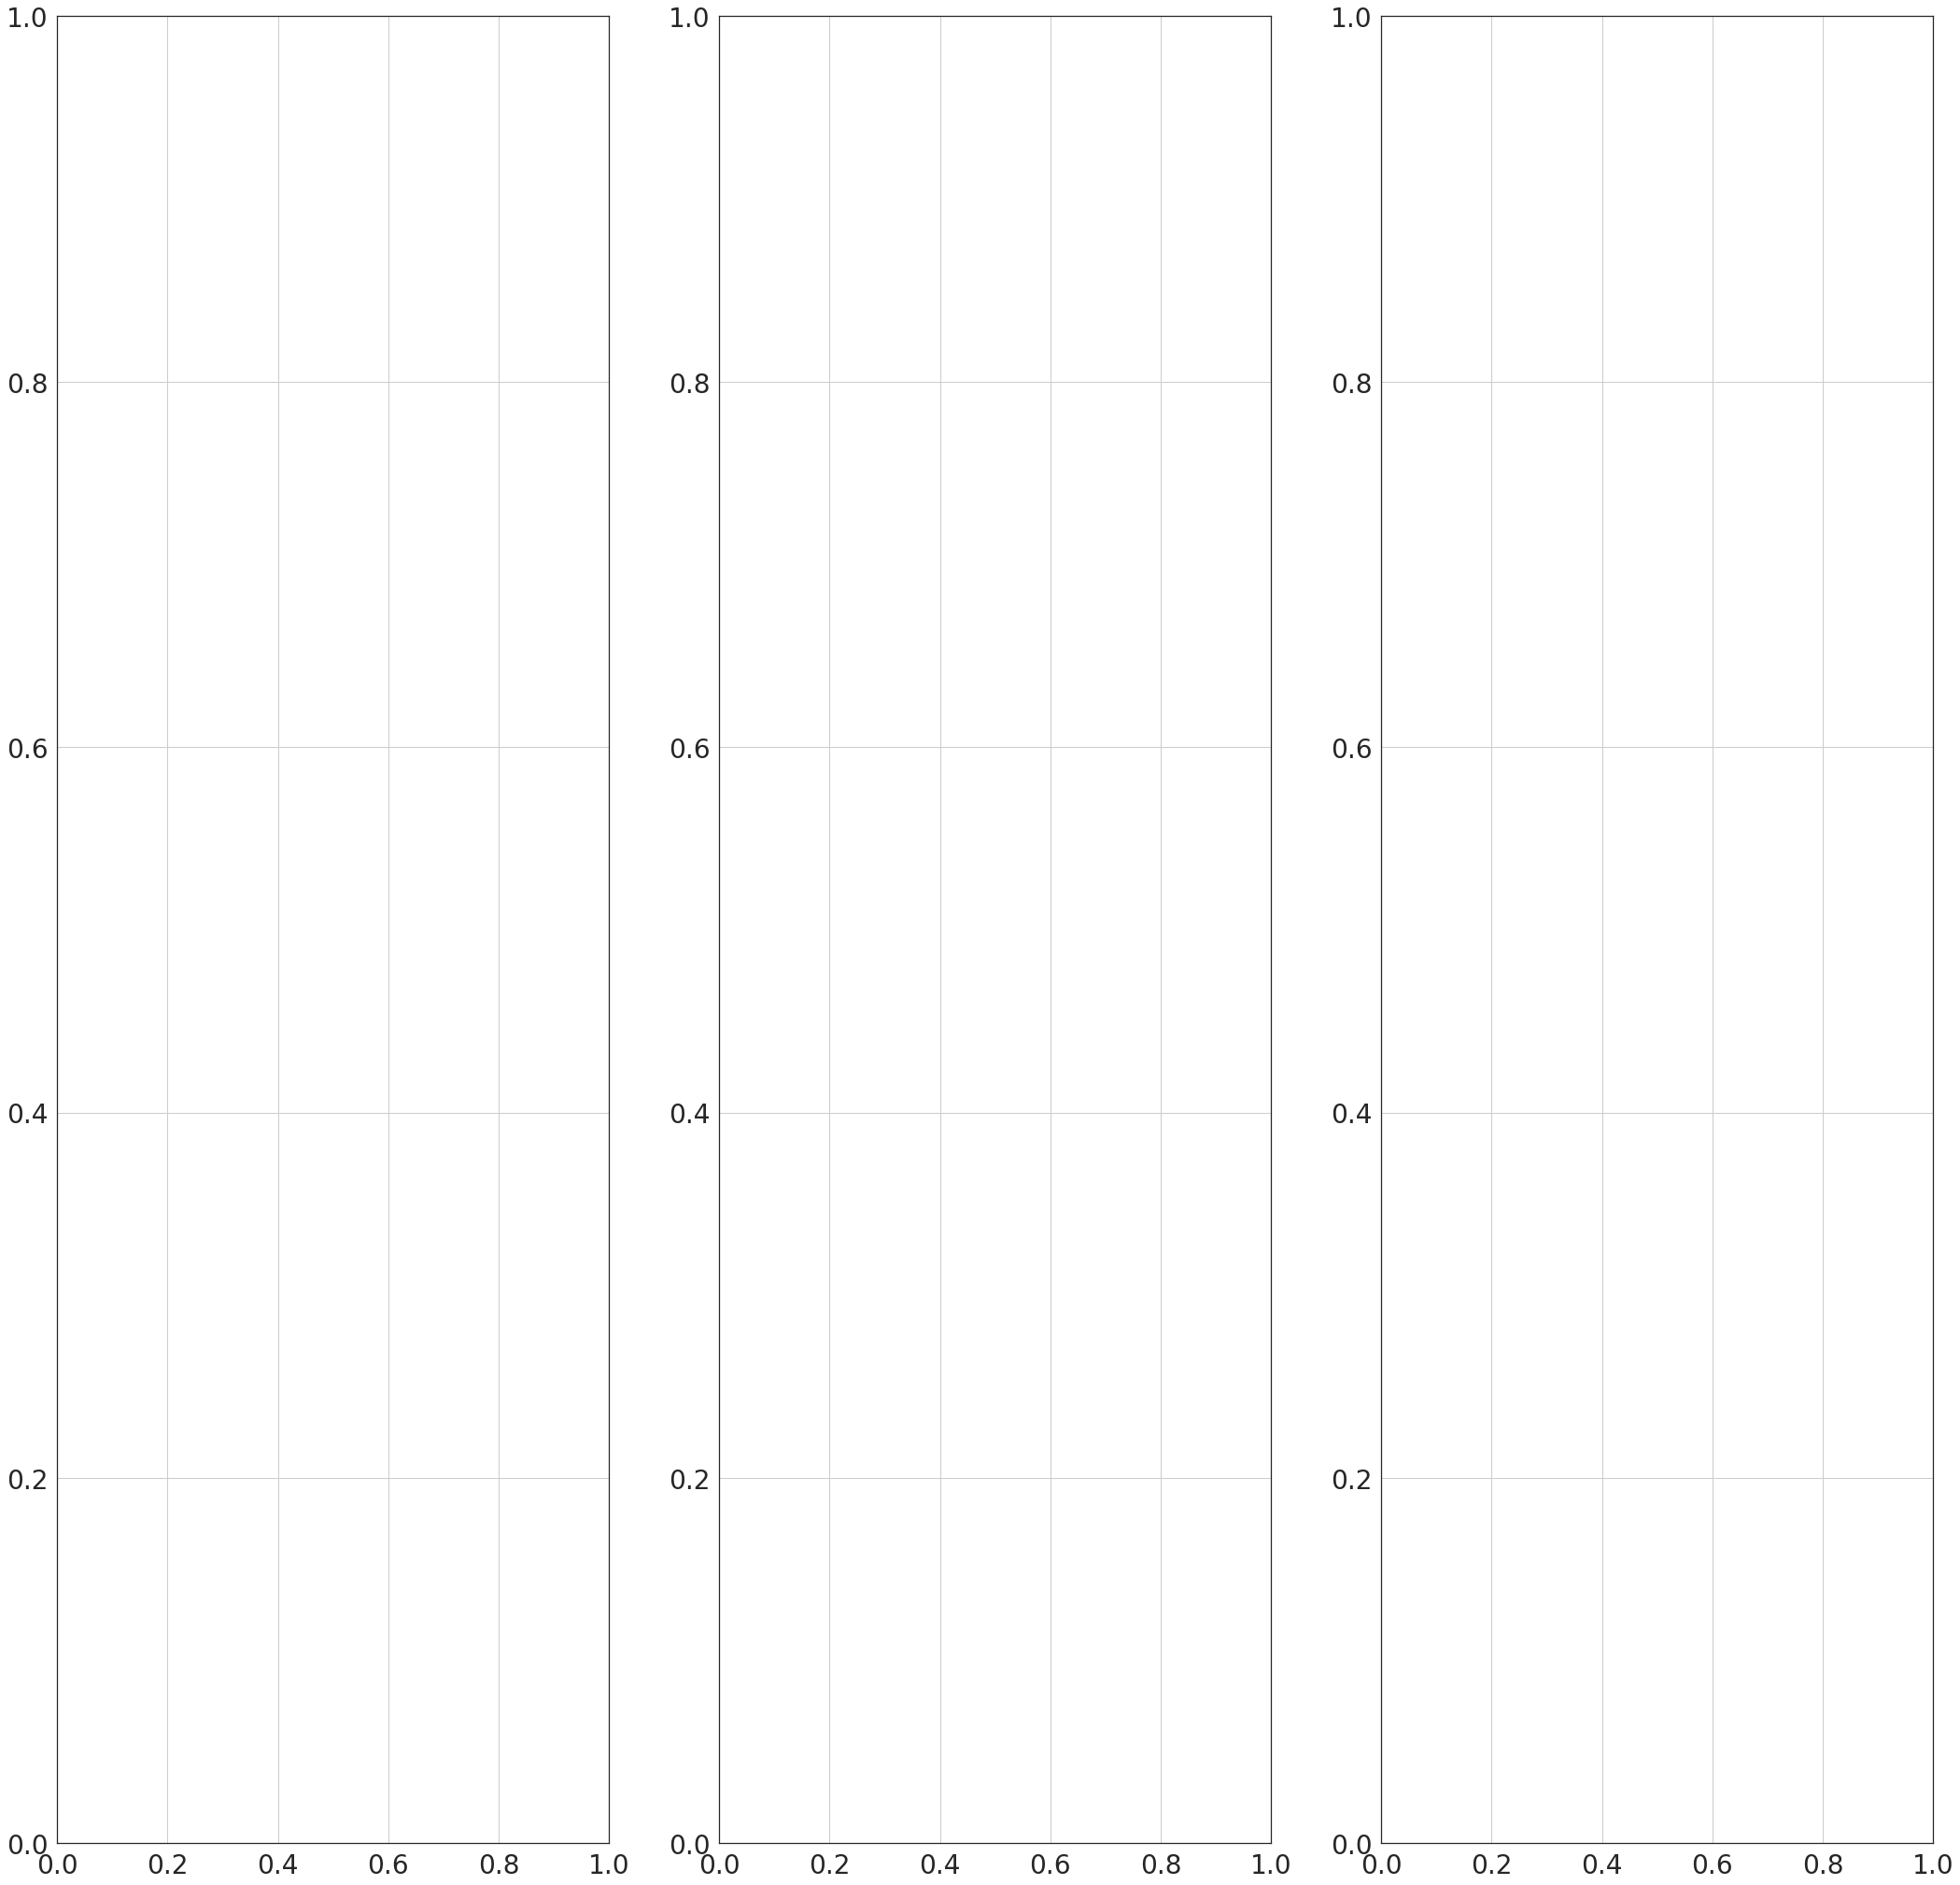

In [126]:
num_bins_map = {
    "BERT Movie Reviews": 10,
    "BERT SNLI": 10,
    "BERT Yelp Polarity": 10,
    "LSTM Movie Reviews": 10,
    "LSTM Yelp Polarity": 10,
}
model_names = sorted(df['model'].unique())[::-1]
fig, axes = plt.subplots(ncols=len(model_names), sharey=False)

for i, model in enumerate(model_names):
    dataset = model_dataset_names[model]
    num_bins = num_bins_map[dataset]
    target_df = df[(df['constraint'] == CONSTRAINT_LEVEL) & (df['model'] == model)].reset_index()
    range_start = target_df['num_words'].min()
    range_end = target_df['num_words'].max()
    bin_size = int((range_end - range_start) / min(range_end - range_start, num_bins))
    bin_steps = range(range_start, range_end, bin_size)

    for search in search_methods:
        if model == "bert-yelp-test" and search == "pso":
            continue
        search = search_method_names[search]
        search_results = target_df[target_df['search'] == search]
        all_successful_attacks = search_results[search_results['result_type']!="Skipped"]
        total_num_attacks = len(search_results[search_results['result_type']!="Skipped"])
        avg_query_counts = []
        for bin_start in bin_steps:
            def num_words_in_range(num_words):
                return (num_words >= (bin_start - 2*bin_size)) and (num_words < (bin_start + 1*bin_size))
            attacks_in_bin = all_successful_attacks[all_successful_attacks['num_words'].apply(num_words_in_range)]
            avg_num_queries = attacks_in_bin['num_queries'].astype(float).mean()
            avg_query_counts.append(avg_num_queries)
        if search == 'Genetic Algorithm':
            axes[i].plot(bin_steps, avg_query_counts, label=search, alpha=.65, c='k', lw=7, linestyle=linestyle_map[search])
        elif search == 'Particle Swarm Optimization':
            axes[i].plot(bin_steps, avg_query_counts, label=search, alpha=.5, c='#000080', lw=7, linestyle=linestyle_map[search])
        else:
            axes[i].plot(bin_steps, avg_query_counts, label=search, alpha=.75, lw=7, linestyle=linestyle_map[search])
        
    axes[i].set_title(dataset)

    if i == 0:
        axes[i].set_ylabel('Number of queries')
    axes[i].set_xlabel('Number of words in each sample')
    if i==len(model_names)-1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=False)

model_type = models[0].split("-")[0]
transformation_type = transformations[0].split("-")[-1]
plt.savefig(f'{FIGURES_DIR}/{model_type}-{transformation_type}-{CONSTRAINT_LEVEL}-queries_vs_num_words.pdf', bbox_inches='tight')

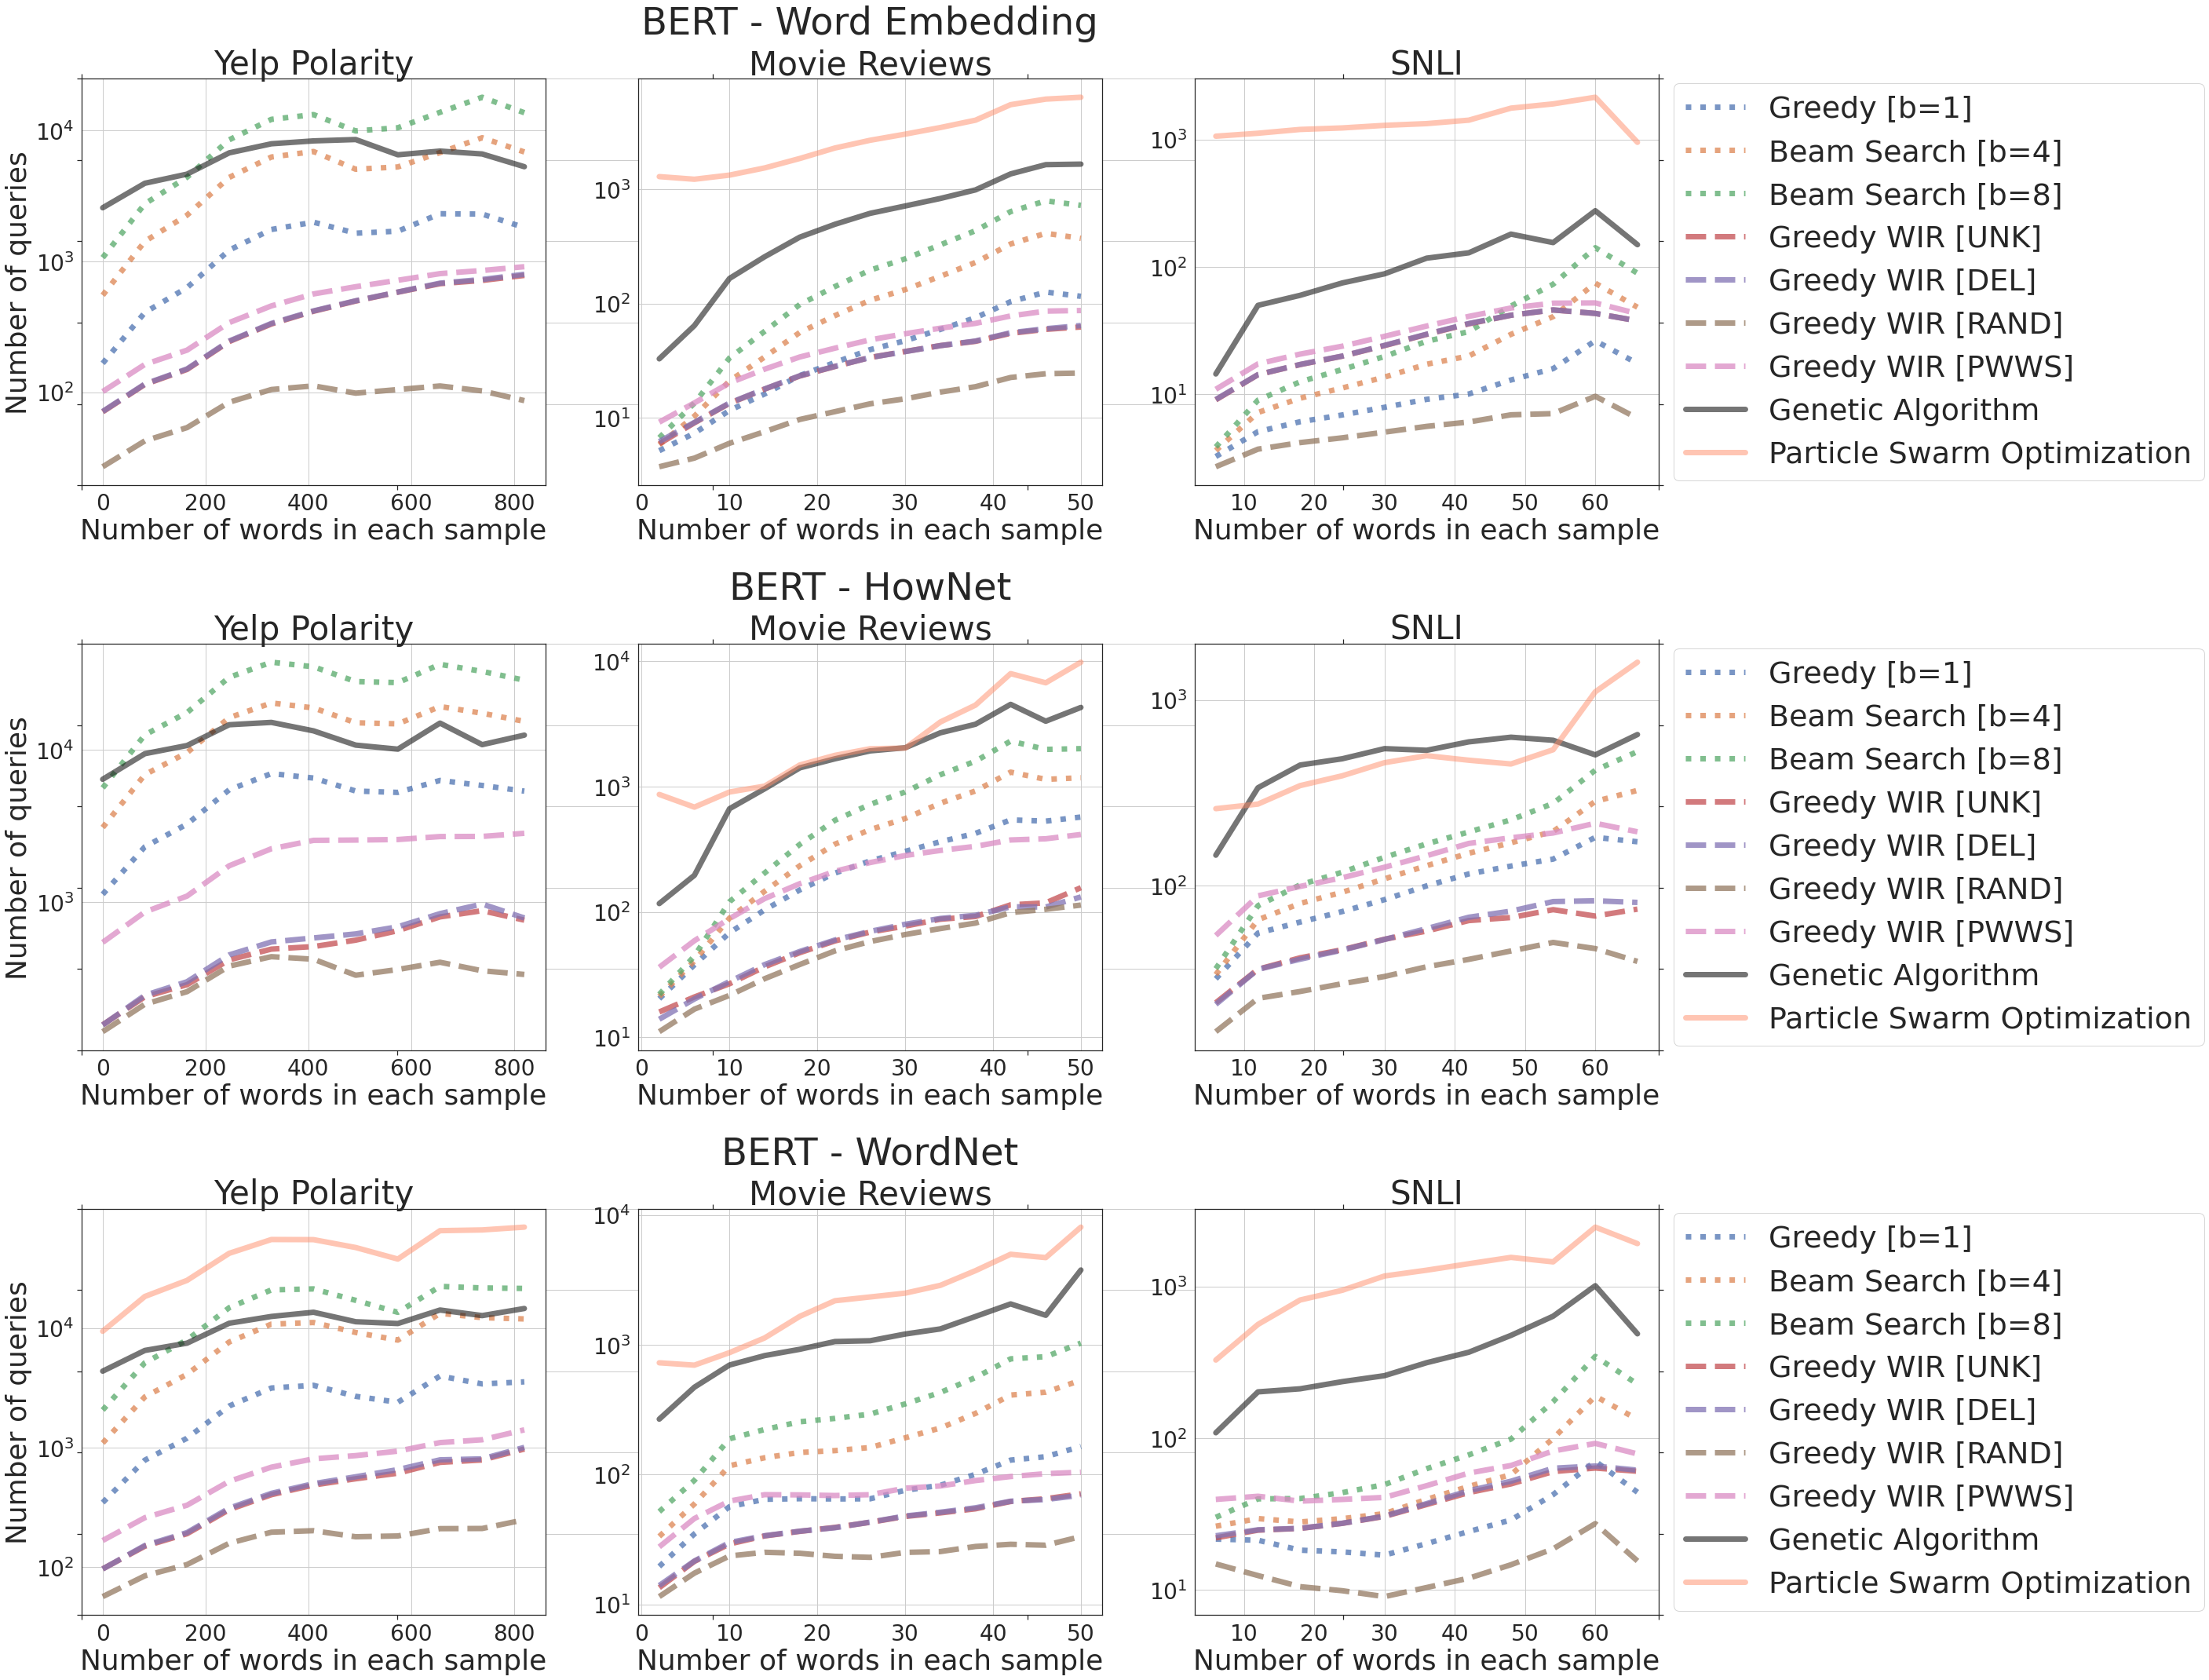

In [133]:
num_bins_map = {
    "Movie Reviews": 10,
    "SNLI": 10,
    "Yelp Polarity": 10,
    "LSTM Movie Reviews": 10,
    "LSTM Yelp Polarity": 10,
}
model_names = sorted(df['model'].unique())[::-1]
fig, big_axes = plt.subplots(len(transformations), sharey=False, sharex=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.39)
SHOW_PERC = True # Whether to attack success rate (percentage) instead of number of total successes.
i = 1
j = 0
for transformation in transformations:
    row_title = f"BERT - {transformation_names[transformation]}"
    plt.text(0.5, 1.11, row_title,
         horizontalalignment='center',
         fontsize=48,
         transform = big_axes[j].transAxes)
    big_axes[j].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_axes[j]._frameon = False
    j += 1
    for model in models:
        ax = fig.add_subplot(len(transformations),len(models),i)
        dataset = model_dataset_names[model]
        num_bins = num_bins_map[dataset]
        target_df = df[(df['constraint'] == CONSTRAINT_LEVEL) & (df['model'] == model) &  (df['transformation'] == transformation)].reset_index()
        range_start = target_df['num_words'].min()
        range_end = target_df['num_words'].max()
        bin_size = int((range_end - range_start) / min(range_end - range_start, num_bins))
        bin_steps = range(range_start, range_end, bin_size)

        for search in search_methods:
            if model == "bert-yelp-test" and search == "pso" and transformation != "word-swap-wordnet":
                continue
            search = search_method_names[search]
            search_results = target_df[target_df['search'] == search]
            all_successful_attacks = search_results[search_results['result_type']!="Skipped"]
            total_num_attacks = len(search_results[search_results['result_type']!="Skipped"])
            avg_query_counts = []
            for bin_start in bin_steps:
                def num_words_in_range(num_words):
                    return (num_words >= (bin_start - 2*bin_size)) and (num_words < (bin_start + 1*bin_size))
                attacks_in_bin = all_successful_attacks[all_successful_attacks['num_words'].apply(num_words_in_range)]
                avg_num_queries = attacks_in_bin['num_queries'].astype(float).mean()
                avg_query_counts.append(avg_num_queries)
            if search == 'Genetic Algorithm':
                ax.plot(bin_steps, avg_query_counts, label=search, alpha=.6, c='k', lw=7, linestyle=linestyle_map[search])
            elif search == 'Particle Swarm Optimization':
                ax.plot(bin_steps, avg_query_counts, label=search, alpha=.5, c='#ff8c69', lw=7, linestyle=linestyle_map[search])
            else:
                ax.plot(bin_steps, avg_query_counts, label=search, alpha=.75, lw=7, linestyle=linestyle_map[search])

        ax.set_title(dataset)
        ax.set_yscale('log')
        if i % 3 == 1:
            ax.set_ylabel('Number of queries')
        ax.set_xlabel('Number of words in each sample')
        if i % 3 == 0:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=False)
        i += 1

model_type = models[0].split("-")[0]
transformation_type = transformations[0].split("-")[-1]
plt.savefig(f'{FIGURES_DIR}/{model_type}-{CONSTRAINT_LEVEL}-queries_vs_num_words.pdf', bbox_inches='tight')

### Number of words

Histograms of number of words per dataset.

In [ ]:
model_names = df['model'].unique()
fig, axes = plt.subplots(ncols=len(model_names), sharey=True)

for i, model in enumerate(model_names):
    dataset = model_dataset_names[model]
    color = sns.color_palette("Paired")[i*2]
    df[df['search'] == 'Beam Search [b=8]'][df['model'] == model][df['constraint'] == 'lax'][df['num_swaps'] > 0] \
        ['num_words'].plot(kind='hist', color=[color], bins=20, title=f'{dataset}', ax=axes[i], legend=False)
    axes[i].set_xlabel('Num. Words')
plt.savefig('num_words_per_dataset.pdf', bbox_inches='tight')

## How does the number of swaps increase with the number of words?

KeyError: 'Skipped'

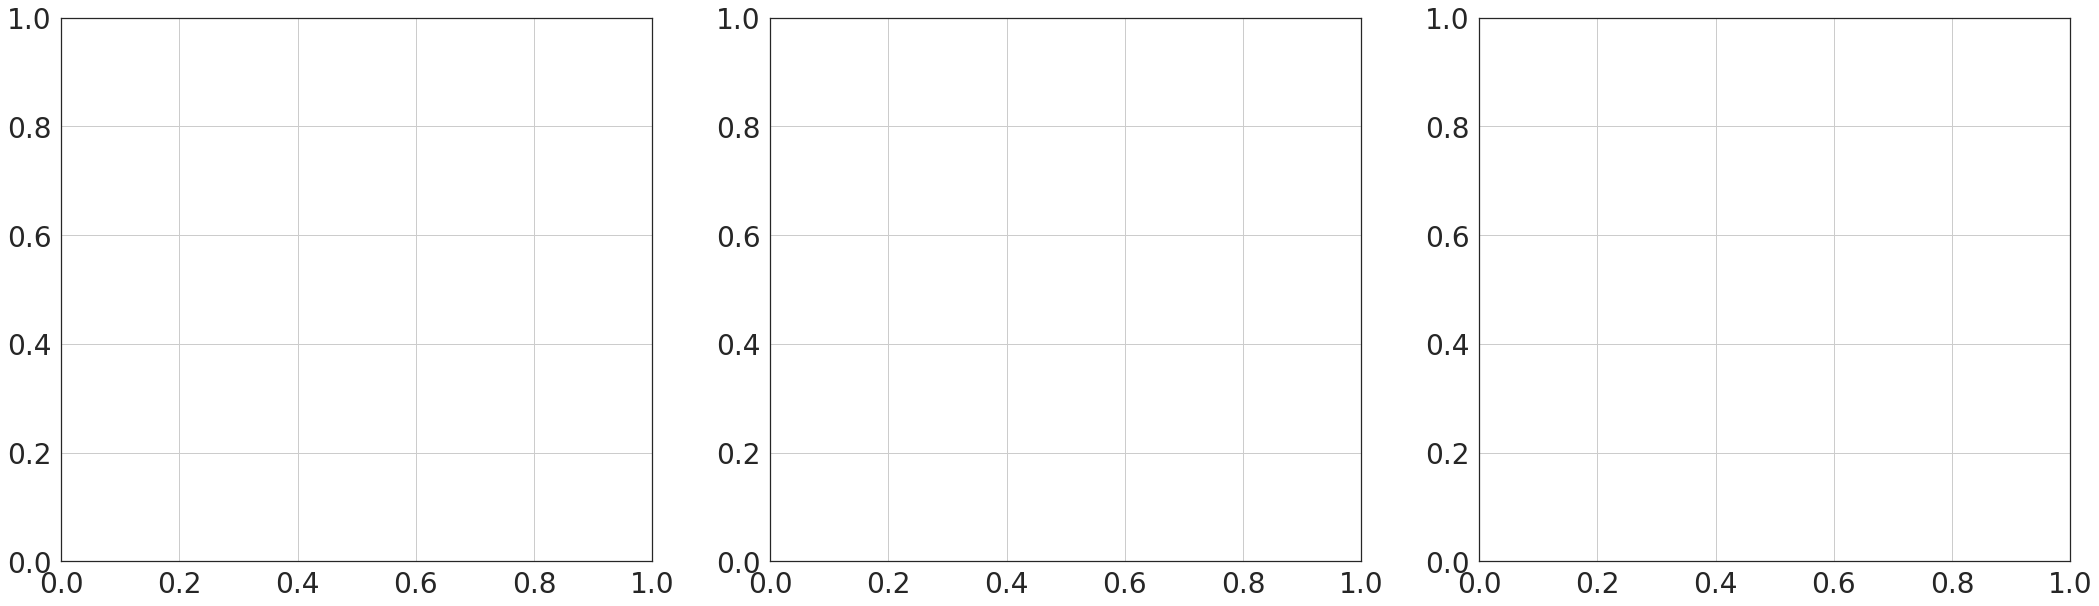

In [65]:
colors = sns.color_palette("Paired")
fig, axes = plt.subplots(ncols=len(model_names), sharey=False)

constraint_level = 'lax'

def color_from_model(model_name):
    if model_name == 'bert-mr-test': return colors[0]
    elif model_name == 'bert-yelp-test': return colors[1]
    elif model_name == 'bert-snli-test': return colors[2]
    else: raise ValueError(f'bad model {model_name}')

for i, model in enumerate(model_names):
    model_df = df[(df['constraint'] == constraint_level) & (df['model'] == model)].reset_index()
    model_df = model_df[~model_df['Skipped']]
    
    dataset = dataset_name_from_model(model)
    axes[i].scatter(model_df['num_words'], model_df['num_swaps'], color=[colors[i*2]], alpha=.9, s=200)
    axes[i].set_title(dataset)
    axes[i].set_xlabel('Num. Words')
    if i == 0:
        axes[i].set_ylabel('Num. Swaps')

plt.savefig(f'word_swaps_vs_num_words_{constraint_level}.pdf', bbox_inches='tight')